# NEURON tutorial: Ball-and-stick electrical model with synapse

Blue Brain Project / EPFL ©2005-2017. This notebook is under a [LGPLv3](https://raw.githubusercontent.com/BlueBrain/MOOC-neurons-and-synapses-2017/master/LICENSE.txt) license.

## Introduction

In this tutorial I will give an introduction to the NEURON simulator. You will learn how to:
* **Load** the NEURON simulator in Python
* Construct a **single compartmental electrical** model
* **Run a simulation**, record the membrane voltage of the model and inject an external current
* **Add ion channels** to the membrane of the model
* Extend the model with a simple **dendrite**
* **Add a synapse** to the model
* **Connect** two cells

Execute the following cell to get the latest version of the software:

In [1]:
import os
os.unsetenv('PYTHONHOME') # Solve an issue with NEURON simulator import

# Install software, ignore some warnings
!pip install -q bluepyopt==1.5.12 matplotlib==2.0.2 numpy==1.13.0 2>&1 | grep -v 'SNIMissingWarning\|InsecurePlatformWarning'

# Show matplotlib plots inline
%matplotlib inline 

## Loading the NEURON simulator

We first import the NEURON Python module

In [2]:
import neuron

The documentation of NEURON is available [here](https://www.neuron.yale.edu/neuron/docs).

Historically the NEURON simulator was controlled using the [HOC language](https://www.neuron.yale.edu/neuron/static/new_doc/programming/hocsyntax.html).
More and more scientists are switching to the Python interface of NEURON. In Python there is something called the [HOCObject](https://www.neuron.yale.edu/neuron/static/docs/help/neuron/neuron/classes/python.html#HocObject) which be accessed by 'h' property of the neuron module, and which contains the HOC functionality of NEURON. For example, to load the 'stdrun.hoc' file which contains some handy functionality one calls the HOC function load_file using:

In [3]:
print neuron.h
# Load external files
neuron.h.load_file("stdrun.hoc");

<TopLevelHocInterpreter>


To make sure we start from a clean state we initialise the simulator

In [4]:
neuron.h.stdinit();

It is important to know that all the values used in NEURON have a certain default unit. 
The list of the defaults can be accessed here: https://www.neuron.yale.edu/neuron/static/docs/units/unitchart.html

For now the most important ones are:
* **length**: micrometer (um)
* **time**: milliseconds (ms)
* **voltage**: millivolt (mV)
* **specific capacitance**: microfarad/cm2 (uf/cm2)

## Constructing a neuron consisting of one compartment

The basic structure of a cell in NEURON is a set of interconnected cylinders (called segments or compartments). Each of these cylinders represents an isopotential part of the cell. The segments between the branch points are grouped together in sections.

![Segments](https://bbp.epfl.ch/public/SimNeuroMOOC/images/TutBallStick/segments.jpg)

Figure adapted from: Schutter, E. D. (2009). Computational modeling methods for neuroscientists. [The MIT Press](https://mitpress.mit.edu/books/computational-modeling-methods-neuroscientists).

Our ball-and-stick model will look like this:

![ecircuit](https://bbp.epfl.ch/public/SimNeuroMOOC/images/TutBallStick/
ballandstick_circuit.jpg)

The soma of our cell is one section of the cell.
Let's start with creating a cell with just a soma:

In [5]:
soma = neuron.h.Section(name='soma')

print "Soma object:", soma
print "Soma object name: ", soma.name()

print "Number of segments in the soma:", soma.nseg

Soma object: soma
Soma object name:  soma
Number of segments in the soma: 1


Just as every other section in NEURON, the soma is represented as a cylinder. We can set the length and diameter of this section.

In [6]:
soma.L = 40
soma.diam = 40
print "Soma length: %f micron" % soma.L 
print "Soma diameter: %f micron" % soma.diam

Soma length: 40.000000 micron
Soma diameter: 40.000000 micron


We can calculate the surface area of the soma using the 'area()' function, and compare it to the equation to calculate the surface area of a cylinder:

In [7]:
soma_area_eq = 2 * neuron.h.PI * soma.L * soma.diam / 2
print "Soma area according to cylinder surface area equation: %f micron^2" % soma_area_eq

# The 0.5 refers to the segment in the middle of the soma
# Because there is only one segment, in this case it refers to the entire soma
soma_area = neuron.h.area(0.5, sec=soma)
print "Soma area according to NEURON: %f micron^2" % soma_area

print "Both values match: %s" % (soma_area_eq == soma_area)

Soma area according to cylinder surface area equation: 5026.548246 micron^2
Soma area according to NEURON: 5026.548246 micron^2
Both values match: True


In a real neuron the soma of a neuron is rather spherical than cylindrical. You might have found it strange that we represent the soma by a cylinder in NEURON. However, the following equation shows that it actually doesn't really matter, the surface area of a sphere with the same radius is exactly the same:

In [8]:
soma_sphere_area_eq = 4 * neuron.h.PI * pow(soma.diam / 2, 2)
print "Soma area according to sphere surface area equation: %f micron^2" % soma_sphere_area_eq

Soma area according to sphere surface area equation: 5026.548246 micron^2


So now we have defined the shape of this single compartmental cell. Electrically the only component that is present for now is the [capacitance](https://en.wikipedia.org/wiki/Capacitance) of the cell membrane. We can retrieve or set the specific membrane capacitance by accessing the 'cm' field. The units of this field are microFarad per cm2. You will see that in NEURON most quantities related to the surface currents are specified per membrane surface area.

In [9]:
print "Specific capacitance: %f uf/cm2" % soma.cm

Specific capacitance: 1.000000 uf/cm2


To get the total capacitance of the soma, we have to multiply this by the surface area. We have to be careful with the units though !

In [10]:
soma_tcap = (soma.cm * (soma_area / pow(1e4, 2)))
print "Total soma capacitance: %f uf" % (soma.cm * (soma_area / pow(1e4, 2)))

Total soma capacitance: 0.000050 uf


## Running a simulation

Let's now run a simulation over time. We will record the [membrane voltage](https://en.wikipedia.org/wiki/Membrane_potential) in the middle of the soma during the simulation:

In [11]:
print "Membrane voltage soma: %f mV" % soma(.5).v # mV

Membrane voltage soma: -65.000000 mV


As you can see the voltage of the cell has been initialised to -65 mV, which roughly corresponds to a typical value in neurons at rest (also called the *resting membrane potential*).

The simulator will integrate the equations over time. The current time is saved in a variable called 't':

In [12]:
print "Current time: %f ms" % neuron.h.t # ms

Current time: 0.000000 ms


When the run() function is called, the simulation will run until a predefined time stored in the the 'tstop' variable. Every timestep, defined by 'dt', a new voltage value will be calculated. 

In [13]:
neuron.h.tstop = 100
print "Simulation stop time: %f ms" % neuron.h.tstop
print "Integration time step: %f ms" % neuron.h.dt

Simulation stop time: 100.000000 ms
Integration time step: 0.025000 ms


To record the time and voltage we create two NEURON Vector objects. These objects have a 'record' method that, when passed a reference to a variable, will record the value of that variable in the vector during the simulation.

In [14]:
time = neuron.h.Vector()
voltage = neuron.h.Vector()

time.record(neuron.h._ref_t)
voltage.record(soma(.5)._ref_v);

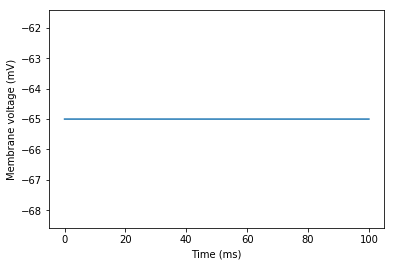

In [15]:
neuron.h.run()

def plot_tv(time_array, voltage_array, show=True, label=None, constants=[]):
    import matplotlib.pyplot as plt
    import numpy
    plt.plot(time_array, voltage_array, label=label)
    for constant in constants:
        plt.plot(time_array, constant*numpy.ones(len(time_array)))
    plt.xlabel('Time (ms)')
    plt.ylabel('Membrane voltage (mV)')
    if show:
        plt.show()
    
plot_tv(time, voltage)

So, basically the voltage has stayed the same over time. We can see why this happened by looking at the following equation NEURON is integrating:

$$C_{m} \frac{dV}{dt} = I_{m}$$

Basically the change in voltage is related to the current going across the membrane. Since we don't have any mechanisms that allow currents to cross the membrane, $I_{m}$ is zero, and our voltage stay the same:

$$dV = I_{m} \frac{dt}{C_{m}} = 0 \frac{dt}{C_{m}}$$

## Injecting a current

Let's now see how we can charge the cell membrane capacitance. For this we stick a virtual electrode in the center of the soma, and inject current using a [current clamp](https://en.wikipedia.org/wiki/Electrophysiology#Current_clamp). We specify an amplitude (in nA), a delay and a duration for our stimulus.

In [16]:
iclamp = neuron.h.IClamp(.5, sec=soma)
iclamp.amp = 0.1 # nA
iclamp.delay = 10 # ms
iclamp.dur = 50 # ms

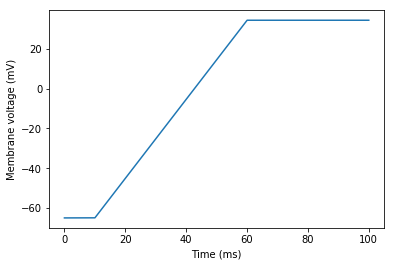

In [17]:
neuron.h.run()

plot_tv(time, voltage)

Let's check if this is the value we expected from the equation

$$C_{m} \frac{dV}{dt} = I_{m}$$

In [18]:
V1 = -65 # Voltage before stimulus, mV
V2 = soma.v # Voltage after stimulus, mV
deltaV = V2 - V1 # Voltage difference, mV
Im = iclamp.amp # nA
deltaT = iclamp.dur # ms
soma_tcap # total soma membrane capacitance, uF

deltaV_eq = Im * deltaT / soma_tcap # in nA * ms / uF == microvolt
deltaV_eq /= 1e3 # Correction factor to get mV

print 'Observed dV: %f mV' % deltaV
print 'Calculated dV: %f mV' % deltaV_eq
print 'Simulated dV matches equation dV: %s' % (deltaV - deltaV_eq < 1e-6)

Observed dV: 99.471839 mV
Calculated dV: 99.471839 mV
Simulated dV matches equation dV: True


## Adding a leak conductance

We'll now start adding transmembrane currents to the model as described in the [Hodgkin-Huxley model](https://en.wikipedia.org/wiki/Hodgkin–Huxley_model).
To enable the equations for this model, we insert the 'hh' mechanism in the soma:

In [19]:
soma.insert('hh');

Now NEURON will integrate the following equation to get calculate the membrane voltage over time:

$$C_{m} dV/dt = -(I_{Na} + I_{K} + I_{leak}) + I_{ext} = -(g_{Na}(V)*(V - E_{Na}) + g_{K}(V)*(V - E_{K}) + g_{leak}*(V - E_{leak})) + I_{ext}$$

We have a sodium and potassium current with voltage dependent conductance and a leakage current with a voltage independent conductance.

Initially we'll set the Na and K conductance to zero:

In [20]:
soma.gkbar_hh = 0.0
soma.gnabar_hh = 0.0

So we get:

$$C_{m} \frac{dV}{dt} = -(g_{leak}*(V - E_{leak})) + I_{ext}$$

The value for the leak conductance is set using the 'gl_hh' attribute ('hh' refers to the name of the mechanism, 'gl' to the name of the parameter inside the 'hh' description). 

In [21]:
soma.gl_hh = 5e-4 # Leak conductance, S/cm^2

The 'el_hh' attribute sets the reversal potential. We call this the 'reversal' potential because the value responses the membrane voltage at which the leak current changes polarity. It's the potential towards this channel 'pushes' the membrane voltage. Let's set the value equal to the resting membrane potential of the cell, so that we have a force that tries to maintain the -65 mV.

In [22]:
el = soma.el_hh = -65 # Reversal potential leak current, mV
print "Reveral of leak current: %f mV" % el

Reveral of leak current: -65.000000 mV


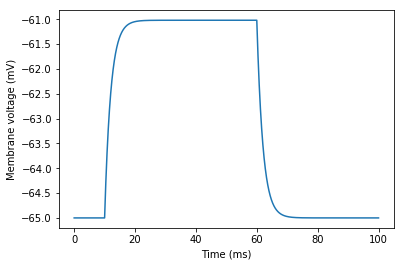

In [23]:
soma.gkbar_hh = 0.0
soma.gnabar_hh = 0.0

neuron.h.tstop = 100

neuron.h.run()

plot_tv(time, voltage)

## Exercise 1

**Question**: Compare this graph to the previous one (section "Injecting a current"). If you look at the equation, do you understand why the voltage flattens out at the end of the stimulus ? 

**Exercise**: When you assume the time derivative of the voltage is zero in the interval between 40 and 60 ms. Calculate the average voltage in that interval. When you do your calculate beware of the units ! Also remember to multiply gl_hh by the surface area of the soma to get the total conductance.

# Adding active ion channels

Now we are adding the active voltage dependent ion channels of the [Hodgkin-Huxley mechanism](https://en.wikipedia.org/wiki/Hodgkin–Huxley_model).

$$C_{m} \frac{dV}{dt} = -(g_{Na}(V)(V - E_{Na}) + g_{K}(V)(V - E_{K}) + g_{leak}(V - E_{leak})) + I_{ext} = -({\overline{g}}_{Na}m^{3}(V - E_{Na}) + {\overline{g}}_{K}h(V - E_{K}) + g_{leak}(V - E_{leak})) + I_{ext}$$

The conductance $g_{Na}$ and $g_{K}$ are decomposed in $\overline{g}_{Na} m^3$ and $\overline{g}_{K} h$. The gnabar and gkbar are parameters of the model that are expressed in siemens/cm^2. They basically represent the density of the ion channels on the membrane. Let's set these to a value different than 0.
When we then run the model, we see that the model now generates action potentials.

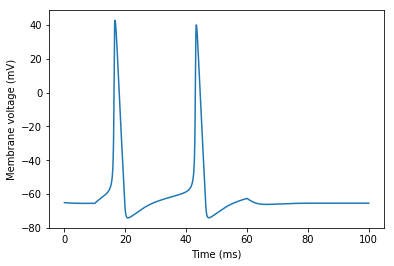

In [24]:
soma.gkbar_hh = 0.01 # in S/cm^2
soma.gnabar_hh = 0.1

neuron.h.run()

plot_tv(time, voltage)

To explain what happened, we can have a look at the reversal potentials of Na, K and leak currents:

Na reversal: 50.000000
K reversal: -77.000000
Leak reversal: -65.000000


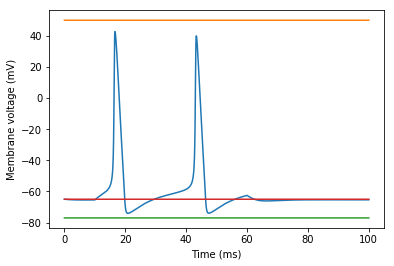

In [25]:
ena = soma.ena # explain e_na
ek = soma.ek
el = soma.el_hh

print "Na reversal: %f" % ena
print "K reversal: %f" % ek
print "Leak reversal: %f" % el

plot_tv(time, voltage, constants=[ena, ek, el])

The three horizontal lines show the reversal potentials. During an action potential the positive ena pulls the membrane potential to 50 mV, but after awhile it gets inactivated and the potassium kicks in to pull the voltage back towards -77 mV. When the cell is at rest, the el keeps the membrane voltage around -65 mV.

## Parameter sensitivity

Let's see what happens when we change some of the parameters. When we change the value of gnabar, it changes the maximum height of the action potential:

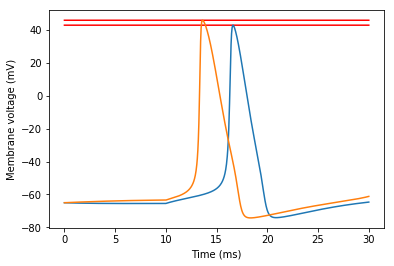

In [26]:
import matplotlib.pyplot as plt
import numpy

for gnabar in [0.1, 0.15]:
    soma.gkbar_hh = 0.01
    soma.gnabar_hh = gnabar

    neuron.h.tstop=30

    neuron.h.run()

    plt.plot(time, max(voltage)*numpy.ones(len(time)), 'r')
    plot_tv(time, voltage, show=False)

plt.show()

When we do this same experiment for many values of gnabar, we can plot the AP height <-> gnabar relationship:

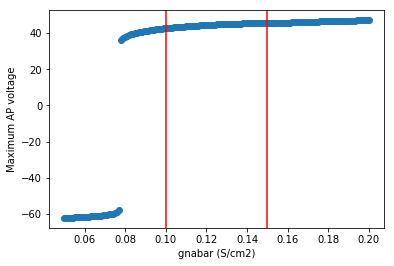

In [27]:
soma.gkbar_hh = 0.01

# definitely mention critical value where state changes
# show something with percentages
# show value we were using before on plot

max_voltages = []
import numpy
gnabar_range = numpy.arange(.05, 0.2, 0.001)
for gnabar in gnabar_range:
    soma.gnabar_hh = gnabar

    neuron.h.run()

    max_voltages.append(max(voltage))

plt.plot(gnabar_range, max_voltages, 'oC0')
plt.xlabel('gnabar (S/cm2)')
plt.ylabel('Maximum AP voltage')
for xs in [0.1, 0.15]:
    plt.axvline(x=xs, color='r')
plt.show()

The two vertical lines show the parameter values we used in the previous plot.
The plotted values are the AP heights at different values of gnabar. Around 0.08 S/cm^2 there is discontinuity, it represent the point at which the neuron starts firing APs.

## Exercise 2

Do the same as above with a range of potassium of [.001, 0.012] and step size 0.001.

Plot the results and try to fit a linear function to the data points.
Use the following numpy function for this:

In [28]:
# linear_coef = numpy.polyfit(gkbar_range, max_voltages, 1)

# print 'Linear equation max_voltage = %f*gkbar + %f' % tuple([x for x in linear_coef])

Send us the two coefficients retrieved by this method.

## Extending the model with a dendrite

Until now we were working with a single compartmental model. We can create an extra dendritic section, and connect it to the soma: 

In [29]:
dend = neuron.h.Section(name='dend')

dend.connect(soma)

dend.L = 400 # micron
dend.diam = 2.0 # micron
dend.nseg = 9 # number of segments in the dendritic section

We will add the hh mechanism to the dendrite, but we will make it passive, meaning that the sodium and potassium channels are disabled.

In [30]:
dend.insert('hh')
dend.el_hh = -65 # Reversal potential leak current, mV
dend.gl_hh = 5e-4 # Leak conductance, S/cm^2

dend.gkbar_hh = 0.0
dend.gnabar_hh = 0.0

Now we can look at what the effect is on our simulation.
We run the simulation twice, once with dendrites, once without.

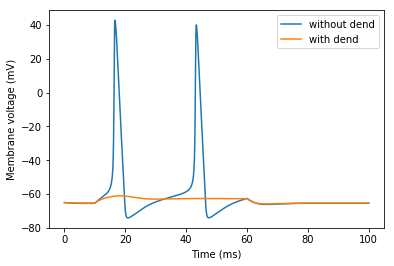

In [31]:
for with_dend in [False, True]:
    neuron.h.tstop = 100

    soma.gkbar_hh = 0.01
    soma.gnabar_hh = 0.1

    if with_dend:
        dend.connect(soma)
    else:
        neuron.h.disconnect(sec=dend) # disconnect dend for now
        
    neuron.h.run()

    plot_tv(time, voltage, show=False, label='with dend' if with_dend else 'without dend')

plt.legend()
plt.show()

## Exercise 3 :

**Question**: What happened ? Why are there no action potentials anymore after adding the dendrite ? What could we do to save the action potentials ?

**Exercise**: Try to save the APs in the soma after the dendrites are connected by changing the values of dend_ra and dend_gl in the code below:

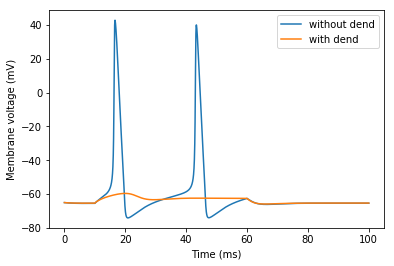

In [32]:
dend_ra = 100
dend_gl = 5e-4

for with_dend in [False, True]:
    # For every addition of mechanism create figure show newer model
    # Lines for reversal potentials Na, K and leak
    neuron.h.tstop = 100

    soma.gkbar_hh = 0.01
    soma.gnabar_hh = 0.1

    dend.el_hh = -65 # Reversal potential leak current, mV
    dend.gl_hh = dend_gl # Leak conductance, S/cm^2
    dend.Ra = dend_ra
    
    if with_dend:
        dend.connect(soma)
    else:
        neuron.h.disconnect(sec=dend) # disconnect dend for now
        
    neuron.h.run()

    # Convert the NEURON vectors to numpy arrays
    time_py = time.to_python()
    voltage_py = voltage.to_python()

    plot_tv(time_py, voltage_py, show=False, label='with dend' if with_dend else 'without dend')

plt.legend()
plt.show()

## Voltage attenuation along the dendrite

While the AP is travelling along this passive dendrite, its height will attenuate.
To show this, we can plot the voltage at different locations along the dendrite:

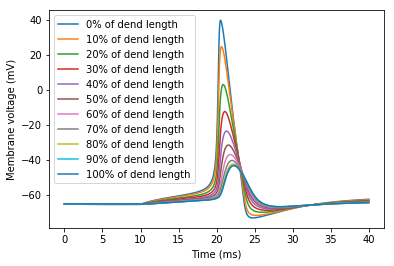

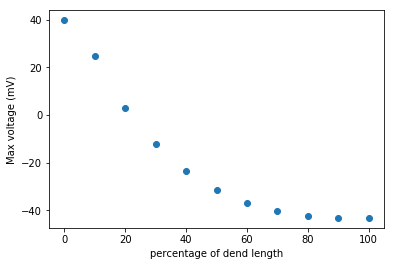

In [33]:
dend.Ra = 200
dend.gl_hh = 5e-4

voltage_dend = {}

# distances are in percentage of dendritic length
# 1.0 is at end of dendrite, 0.0 at connection with soma
distance_range = numpy.arange(0, 1.1, 0.1)
for distance in distance_range:
    voltage_dend[distance] = neuron.h.Vector()
    voltage_dend[distance].record(dend(distance)._ref_v);
 
neuron.h.tstop = 40
neuron.h.run()

for distance in distance_range:
    plot_tv(time, voltage_dend[distance], show=False, label='%.0f%% of dend length' % (distance*100))
    
plt.legend()
plt.show()

max_voltage_dend = []
for distance in distance_range:
    max_voltage_dend.append(max(voltage_dend[distance]))

plt.plot(distance_range*100, max_voltage_dend, 'o')
plt.xlabel('percentage of dend length')
plt.ylabel('Max voltage (mV)')
plt.show()

## Adding a synapse

When we want to start connecting cells, we will need chemical synapses. 
In NEURON a synapse is representing as a 'point process'. Such processes are located at a specific location along the morphology and they will in general inject some current into the cell when activated (the current clamp we saw earlier was also a point process).

NEURON has several builtin synapse types. In this tutorial we will use the ExpSyn process.
This is a synapse with single exponential decay of its conductance.
The equation to calculate the current generated by this synapse is:

$$I_{syn} = g_{syn}*(V_{m} - E_{syn})$$

with

$$\frac{dg_{syn}}{dt} = \frac{-g_{syn}}{\tau}$$

$\tau$ is the time constant of the decay.

Every time an event arrives at the synapse, the conductance of the synapse is increased by its weight (in microsiemens)

$$g_{syn} = g_{syn} + weight$$


Let's add such a synapse to the dendrite:

In [34]:
expsyn = neuron.h.ExpSyn(.5, sec=dend) # We add a synapse to the middle (.5) of the dendrite

To stimulate the synapse we create a NetStim object. It basically plays the role of a presynaptic cell. The attributes of this object specify how many times we want to stimulate, with which interval and when we want to start. The noise attribute determines the stochasticity of the process, 0 means completely regular firing.

In [35]:
netstim = neuron.h.NetStim()
netstim.interval = 5
netstim.number = 5
netstim.start = 20
netstim.noise = 0

This NetStim needs to be connected to the cell. A NetCon object acts as a connector between a presynaptic and postsynaptic cell.

In [36]:
netcon = neuron.h.NetCon(netstim, expsyn)
netcon.weight[0] = 1.0

And now we can simulate:

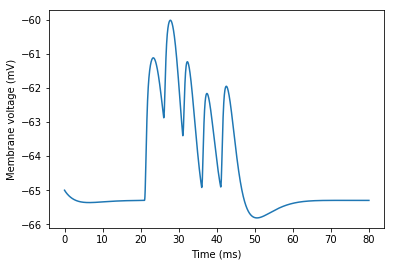

In [37]:
iclamp.amp = 0
neuron.h.tstop = 80
neuron.h.run()

plot_tv(time, voltage)

As you can see, there are 5 events arriving in the postsynaptic cell. Each event injects a certain current in the cell, and slowly decays afterwards. When synaptic events occur in quick success they sum up.

## Connecting two cells

In our last example we connect two cells together. 
We make a presynaptic cell and inject a current clamp into it so that it spikes. 
By connecting this cell to a postsynaptic cell, that doesn't receive a current clamp, we can make the second cell fire also.

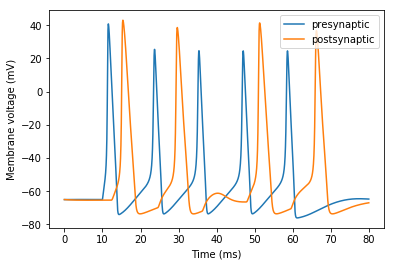

In [38]:
soma_pre = neuron.h.Section(name='soma')
soma_pre.L = 40
soma_pre.diam = 40
soma_pre.insert('hh')

iclamp_pre = neuron.h.IClamp(.5, sec=soma_pre)
iclamp_pre.amp = 1.0 # nA
iclamp_pre.delay = 10 # ms
iclamp_pre.dur = 50 # ms

time_pre = neuron.h.Vector()
voltage_pre = neuron.h.Vector()

time_pre.record(neuron.h._ref_t)
voltage_pre.record(soma_pre(.5)._ref_v);

expsyn.tau = .9
netcon_pre = neuron.h.NetCon(soma_pre(.5)._ref_v, expsyn, sec=soma_pre)
netcon_pre.weight[0] = 1

if 'netstim' in locals():
    del netstim
if 'netcon' in locals():
    del netcon

neuron.h.run()

time_py = time.to_python()
voltage_py = voltage.to_python()

plot_tv(time_pre, voltage_pre, show=False, label='presynaptic')
plot_tv(time, voltage, show=False, label='postsynaptic')
plt.legend()
plt.show()

del netcon_pre